# Deep Hedging with a simple network structure

We consider a one-dimensional Black-Scholes model which is given by the following dynamics
\begin{align*}
    S_0 
=   s_0
\qquad \text{and} \qquad
    S_t 
=   S_0 \exp{\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)},
    \qquad t \in [0, T]
\end{align*}
where $\mu \in \mathbb{R}$, $\sigma, s_0> 0$ and $W_t$ is a one-dimensional Brownian motion. \\

---

Our goal is to compare the strategies $\delta_{k}^{\theta}$ and $\delta_{k}^{BS}$ at a fixed time-point $t_k=15/365$ conditional on $S_{k}$.
If we want to make such a comparison however we face the following problem:
The model hedge strategy $\delta_{k}^{\text{BS}} = \Delta_{t_k} = \partial_x u(t_k, S_{t_k})$ only depends on the current price (and some fixed model parameters).
On the other hand, the neural network strategy $\delta^{\theta}_k = F^{\theta_k}(I_k, \delta^{\theta}_{k-1})$ takes an additional input $\delta^{\theta}_{k-1}$.
Hence, to compare the strategies, we use a much simpler network structure which only takes the current information as an input, namely $\delta^{\theta}_{k} = F^{\theta_k}(I_k)$.

## Setup

Next, we import some required packages and our own modules.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from torch import nn
from torch.optim import Adam

from modules.utils import save_model, compare_strategy, compare_hedgers
from modules.market_impact import ZeroImpact
from modules.transaction_cost import ZeroCost
from modules.risk_measure import AverageValueAtRisk
from modules.derivative import EuropeanOption
from modules.black_scholes import BlackScholesModel, BlackScholesHedger
from modules.deep_hedger import DeepHedger, SimpleDeepHedger, train

If a GPU is available, we would like to use the GPU to speed up the training process.
Unfortunately, for some reason, training with the GPU is slower than without! 
For this reason we will use the CPU for now!

In [2]:
# device settings
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cpu


## Setting

We choose a time horizon of 30 trading days with daily rebalancing, i.e. $T= 30/365$ and $n=30$ where the trading dates are given by $t_{k} = k/365$ for $k = 0, \ldots, n$.

Our goal is to hedge a call option with maturity $T$ and strike price $K = s_0$, i.e. $Z = (S_T - K)^+$.
Recall that the unique risk-neutral price of the call option at time $t$ is given by

\begin{equation}
    u(t, S_t) := S_t \Phi\left(d_{+}\right)-K e^{-r(T-t)} \Phi\left(d_{-}\right), \quad t \in[0, T],
\end{equation}

where $\Phi\colon\mathbb{R}\to[0,1]$ denotes the cumulative distribution function of a standard normal random variable and
\begin{align*}
    d_{\pm} = \frac{\log (S_t / K)+\left(r \pm \sigma^{2} / 2\right)(T-t)}{\sigma \sqrt{T-t}}.
\end{align*}

Moreover, the replication strategy is given by 

\begin{equation}
    \Delta_t := \partial_x u(t, S_t) = \Phi(d_+), \qquad t \in [0,T],
\end{equation}

where $\partial_x u$ denotes the partial derivative of $u$ with the respect to the second component.

In [3]:
# define parameters
d = 1  # number of hedging instruments 
T = 30/365  # maturity
N = 30  # time discretization
dt = T/N  # time step

# Black-Scholes model parameters
s0 = (100.0)  # inital value(s)
sigma = 0.2  # volatility
model = BlackScholesModel(initial_value=s0, sigma=sigma, dt=dt, device=my_device)

# derivative to hedge
call = True
strike = s0 
derivative = EuropeanOption(call=call, strike=strike, maturity=T)
price = None

Note that the risk-neutral price can be easily computed by applying the Black-Scholes formula $q := u(0, s_0)$.

In [4]:
q = BlackScholesHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma).price().item()
print('The risk neutral price is given by {:.4f}.'.format(q))

The risk neutral price is given by 2.2871.


We choose $\rho = \text{AVaR}_{\alpha}$ as our risk measure, as this allows to easily model different risk-preferences by adjusting the parameter $\alpha \in (0, 1)$ appropriately.
In particular, we choose $\alpha = 0.5$ as this seems to yield good results.
Further we assume no market frictions such as market impact and transaction costs, i.e. $C_{T} \equiv 0$.


In [5]:
# risk measure
alpha = 0.5
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 0.0
market_impact = ZeroImpact()

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

## Training the (simple) neural network model


As mentioned above, we use a much simpler network structure, namely $\delta^{\theta}_{k} = F^{\theta_k}(I_k)$, to compare the strategies at a fixed time-point $t_k=15/365$ conditional on $S_{k}$.

We use Adam to optimize our neural network and we choose a learning rate of $\eta = 0.005$ and a batch size of $256$.

In [6]:
# training parameters
n_epochs = 0  # number of epochs (set to 0 for no training)
n_samples = 4*1000000  # number of samples
validation_samples = n_samples // 4  # number of validation samples
batch_size = 256  # batch size
lr = 0.005  # learning rate

In [7]:
path = 'saved_models/black_scholes_deep_hedging'  # path to saved models
file_name = 'simple_hedger_bs'

use_pretrained = True  # use pre-trained model
saving_model = False  # save model after training

We have implented the hedging strategy with a simple network structure in the class ``SimpleDeepHedger``.

 

In [8]:
simple_hedger = SimpleDeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
optimizer = Adam(simple_hedger.parameters(), lr=lr)
if use_pretrained:  # load model
    simple_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)
    print('model loaded')

model loaded


We can now train our model with the specified training parameters and plot the training and test loss during each epoch.

0it [00:00, ?it/s]

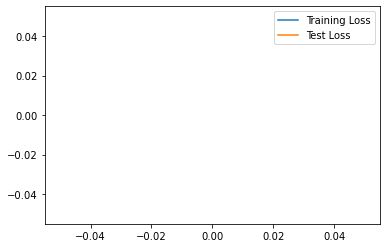

In [9]:
train_history, test_history = train(simple_hedger, derivative, risk_measure, optimizer, 
                                    price=price, n_samples=n_samples, validation_samples=validation_samples, n_epochs=n_epochs, batch_size=batch_size)
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.legend()
plt.show()

In [10]:
if saving_model:
    save_model(simple_hedger, file_name, path)
    print('model saved!')

## Results

After training the model, we can now plot $\delta^{\theta}_k$ and $\delta^{\text{BS}}_k$ conditional on $S_{k}$ on a grid for a fixed-time point $t_k = 15/365$.

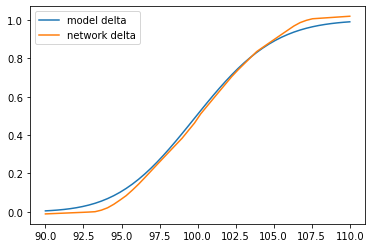

In [11]:
black_scholes_hedger = BlackScholesHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma,
                                          market_impact=market_impact, transaction_cost=transaction_cost)
compare_strategy(hedgers=[black_scholes_hedger, simple_hedger], labels=['model delta', 'network delta'], n_step=15)

It is interesting to note that the hedging performance for this simpler structure is very similar compared to the semi-recurrent network structure.

To see this let us first load the pre-trained model for the neural network with a semi-recurrent structure.

In [12]:
deep_hedger = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
deep_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, 'deep_hedger_bs')), strict=False)
print('model loaded')

model loaded


Finally, we can compare the PnL performance of both strategies.
As expected they are very similar, since we assumed no market frictions such as transaction costs or market impact.

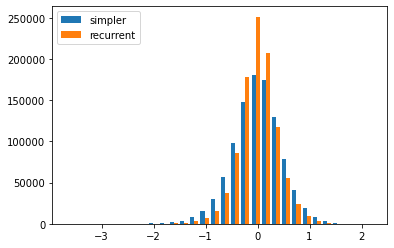

In [13]:
compare_hedgers(hedgers=[simple_hedger, deep_hedger], model=model, derivative=derivative,
                labels=['simpler', 'recurrent'], n_samples=validation_samples, price=q)